<a href="https://colab.research.google.com/github/qkrwoghd04/Image-text_fusion_for_binary_classification_using_BERT-ViT/blob/master/code/Image%26Text_fusion_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification model based on BERT

In [1]:
# Install BERT for tf2 module
!pip install bert-for-tf2
# Install sentencepiece library for text cleaning
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30510 sha256=b9dc24a7c1a5aca661b5a64a26bce4b64c63fb24b6f4e0be131521437b2512da
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19455 sha256=b2cb16358915cafc4f44a1f775b800df2d72511753ce7a9019f7839faaab70d5
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=989762946759cfec3c99d38f1fe3cf2cffffc1964e5c229f76f6e70ded2be92f
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_hub as hub
from keras import layers
from keras import callbacks
from keras import optimizers
from keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import bert
import os
import numpy as np
import re
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# 파일 경로 정의
train_csv_path = "/content/drive/MyDrive/image_dataset/processed/train_captions.csv"
test_csv_path = "/content/drive/MyDrive/image_dataset/processed/test_captions.csv"

# Import the training and test .csv files
colnames = ['image_path', 'caption', 'label']
train = pd.read_csv(train_csv_path, names=colnames, header=0)
test = pd.read_csv(test_csv_path, names=colnames, header=0)

# Sort values by 'image_path'
test = test.sort_values('image_path')
train = train.sort_values('image_path')

In [4]:
train.head()

,image_path,caption,label
0,Fall_001.jpg,a man lying on the ground in a hallway.,Fall
1,Fall_002.jpg,a person lying on the ground in front of a wi...,Fall
2,Fall_003.jpg,a man in a purple shirt lying on the floor.,Fall
3,Fall_004.jpg,a man lying on the ground in a room.,Fall
4,Fall_005.jpg,a man lying on the ground in a room.,Fall


In [5]:
# Check the shapes
print("train samples:",train.shape[0])
print("test samples:",test.shape[0])

train samples: 400
test samples: 40


In [50]:
# Cleaning text function

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = sentence.lower()

    return sentence

def remove_tags(text):
    return TAG_RE.sub('', text)

TAG_RE = re.compile(r'<[^>]+>')
vec_preprocess_text = np.vectorize(preprocess_text)

In [51]:
# Check number of classes
nClasses = train.label.nunique()

In [52]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 레이블 인코더를 초기화합니다.
encoder = LabelEncoder()

# 텍스트 전처리 함수 'vec_preprocess_text'를 사용하여 캡션을 전처리합니다.
processed_train = vec_preprocess_text(train.caption.values)
processed_test = vec_preprocess_text(test.caption.values)

# 'train.label.values'를 사용하여 트레인 세트의 레이블을 인코딩하고,
# 'test.label.values'를 사용하여 테스트 세트의 레이블을 인코딩합니다.
encoded_labels_train = encoder.fit_transform(train.label.values)
encoded_labels_test = encoder.transform(test.label.values) # fit_transform이 아닌 transform을 사용

# 레이블의 총 클래스 수를 얻습니다.
nClasses = len(encoder.classes_)

# 인코딩된 레이블을 원-핫 인코딩 형태로 변환합니다.
labels_train = to_categorical(encoded_labels_train, num_classes=nClasses)
labels_test = to_categorical(encoded_labels_test, num_classes=nClasses)

print("Processed text sample:", processed_train[0])
print("Shape of train labels:", labels_train.shape)


Processed text sample:  man lying on the ground in hallway 
Shape of train labels: (400, 2)


In [53]:
# Import the BERT BASE model from Tensorflow HUB (layer, vocab_file and tokenizer)
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [54]:
# Preprocessing of texts according to BERT

def get_masks(text, max_length):
    """Mask for padding"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))
vec_get_masks = np.vectorize(get_masks, signature = '(),()->(n)')

def get_segments(text, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    segments = []
    current_segment_id = 0
    with_tags = ["[CLS]"] + tokens + ["[SEP]"]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))
vec_get_segments = np.vectorize(get_segments, signature = '(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids
vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')


def prepare(text_array, tokenizer, max_length = 128):

    ids = vec_get_ids(text_array,
                      tokenizer,
                      max_length).squeeze()
    masks = vec_get_masks(text_array,
                      max_length).squeeze()
    segments = vec_get_segments(text_array,
                      max_length).squeeze()

    return ids, segments, masks

In [55]:
max_length = 15
ids_train, segments_train, masks_train = prepare(processed_train,
                                                 tokenizer,
                                                 max_length)
ids_test, segments_test, masks_test = prepare(processed_test,
                                               tokenizer,
                                               max_length)

In [56]:
def print_token_info(token_ids, input_mask, segment_ids, tokenizer):
    # 토큰 ID에서 토큰으로 변환
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    # 출력을 위한 데이터 프레임 생성
    token_info = pd.DataFrame({
        'Token': tokens,
        'ID': token_ids,
        'Mask': input_mask,
        'Segment': segment_ids
    })

    # 데이터 프레임 출력
    display(pd.DataFrame(token_info.T))

# 예제 데이터를 사용하여 출력
index = 210  # 첫 번째 샘플을 출력하기 위한 인덱스
print_token_info(ids_train[index], masks_train[index], segments_train[index], tokenizer)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Token,[CLS],woman,lying,on,bed,with,pillows,[SEP],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD],[PAD]
ID,101,2450,4688,2006,2793,2007,17860,102,0,0,0,0,0,0,0
Mask,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
Segment,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_masks")
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")
den_out, seq_out = bert_layer([input_word_ids, input_mask, segment_ids])

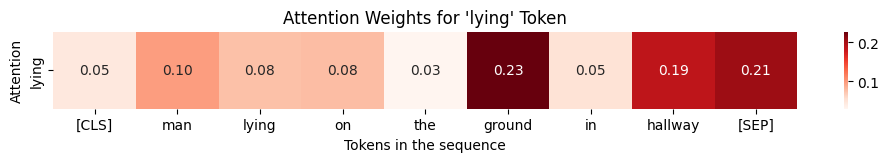

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertModel, BertTokenizer

# BERT 모델과 토크나이저 로드
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 입력 준비
inputs = tokenizer("man lying on the ground in hallway", return_tensors="pt")
input_ids = inputs["input_ids"]

# 모델 실행
outputs = model(**inputs)

# Attention weights 추출
attentions = outputs.attentions  # 각 layer의 attention weights

# "lying" 토큰의 인덱스 찾기
lying_index = (input_ids[0] == tokenizer.convert_tokens_to_ids('lying')).nonzero(as_tuple=True)[0].item()

# 첫 번째 어텐션 레이어의 첫 번째 헤드에서 "lying"에 대한 attention 시각화
attention = attentions[0][0, 0, :, :]  # (num_heads, query_length, key_length) 중 첫 번째 layer, 첫 번째 head 선택
plt.figure(figsize=(12, 1))
sns.heatmap(attention[lying_index, :].unsqueeze(0).detach().numpy(), annot=True, cbar=True, fmt=".2f",cmap='Reds', xticklabels=tokenizer.convert_ids_to_tokens(input_ids[0]), yticklabels=["lying"])
plt.title("Attention Weights for 'lying' Token")
plt.xlabel("Tokens in the sequence")
plt.ylabel("Attention")
plt.savefig("/content/drive/MyDrive/heatmap.png")  # 현재 그림을 파일로 저장
plt.show()


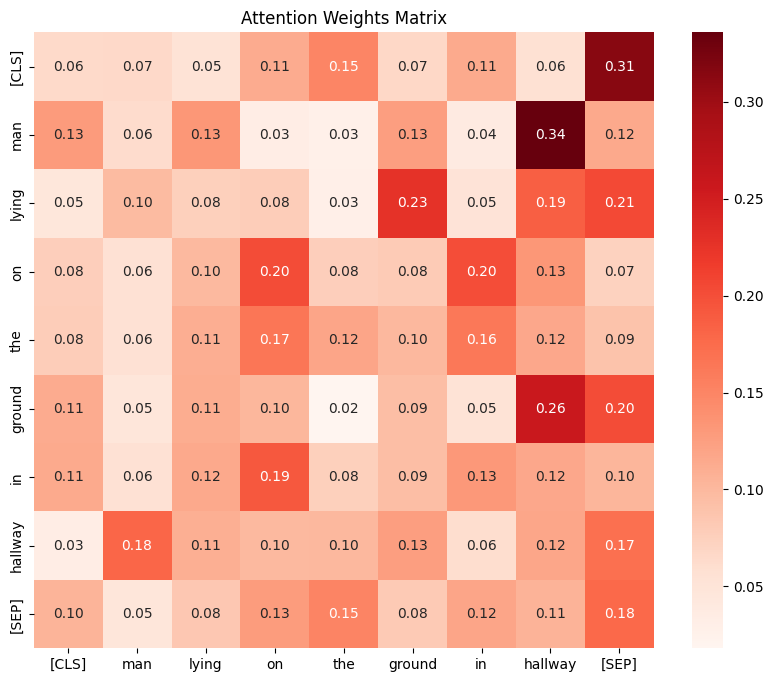

In [60]:
# BERT 모델과 토크나이저 로드
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 입력 준비
text = "man lying on the ground in hallway"
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"]

# 모델 실행
outputs = model(**inputs)

# Attention weights 추출
attentions = outputs.attentions  # 각 layer의 attention weights

# 토큰 리스트 얻기
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# 첫 번째 attention layer의 첫 번째 head 선택
attention = attentions[0][0, 0, :, :].detach().numpy()  # (query_length, key_length)

# 전체 토큰에 대한 attention 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(attention, annot=True, cbar=True, fmt=".2f", cmap='Reds', xticklabels=tokens, yticklabels=tokens)
plt.title("Attention Weights Matrix")
plt.savefig("/content/drive/MyDrive/heatmap_sentence.png")  # 현재 그림을 파일로 저장
plt.show()


In [61]:
# Classification Model
input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")
den_out, seq_out = bert_layer([input_word_ids, input_mask, segment_ids])

X = layers.LSTM(128)(seq_out)
X = layers.Dropout(0.5)(X)
X = layers.Dense(64, activation="relu")(X)
X = layers.Dropout(0.5)(X)
output = layers.Dense(nClasses, activation = 'softmax')(X)

BERT_MODEL = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[output])

In [62]:
# Adam optimizer
opt = optimizers.Adam(learning_rate=.001)

# Compile model
BERT_MODEL.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])


In [63]:
BERT_MODEL.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 15)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 15)]                 0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 15)]                 0         []                            
                                                                                                  
 keras_layer_3 (KerasLayer)  [(None, 768),                1094822   ['input_word_ids[0][0]',

In [64]:
es = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [65]:
# Google Drive 마운트 경로
drive_path = "/content/drive/MyDrive/image_dataset/processed"

# 새로운 로그 저장 디렉토리 경로
log_dir = os.path.join(drive_path, "BERT_LSTM")

# 디렉토리가 존재하지 않는 경우 생성
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# 체크포인트 및 로그 파일 경로 설정
checkpoint_path = os.path.join(log_dir, "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
csv_logger_path = os.path.join(log_dir, 'BERT_LSTM.log')

# Setup callbacks, logs and early stopping condition
cp = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
csv_logger = tf.keras.callbacks.CSVLogger(csv_logger_path)

In [66]:
# Reduce learning rate if no improvement is observed
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

In [67]:
history = BERT_MODEL.fit([ids_train, masks_train, segments_train],
          labels_train,
          epochs = 20,
          batch_size = 16,
          validation_split = 0.2,
          callbacks = [csv_logger, reduce_lr , es])


Epoch 1/20
20/20 [==============================] - 24s 563ms/step - loss: 0.4615 - accuracy: 0.7625 - val_loss: 0.6291 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/20
20/20 [==============================] - 7s 375ms/step - loss: 0.3968 - accuracy: 0.8500 - val_loss: 0.3214 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 3/20
20/20 [==============================] - 8s 386ms/step - loss: 0.3078 - accuracy: 0.9187 - val_loss: 0.6515 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 4/20
20/20 [==============================] - 7s 368ms/step - loss: 0.2546 - accuracy: 0.9000 - val_loss: 0.4667 - val_accuracy: 0.8250 - lr: 1.0000e-04
Epoch 5/20
20/20 [==============================] - 7s 373ms/step - loss: 0.2770 - accuracy: 0.8875 - val_loss: 0.4757 - val_accuracy: 0.8250 - lr: 1.0000e-05
Epoch 6/20
20/20 [==============================] - 7s 359ms/step - loss: 0.2709 - accuracy: 0.9000 - val_loss: 0.4862 - val_accuracy: 0.8125 - lr: 1.0000e-05
Epoch 7/20
20/20 [==============================] - 8s 40

In [69]:
# Load the log file
df = pd.read_csv(r'/content/drive/MyDrive/image_dataset/processed/BERT_LSTM/BERT_LSTM.log')

In [70]:
# Training and Test accuracy
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [71]:
# Training and Test loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [72]:
BERT_MODEL.evaluate([ids_test, masks_test, segments_test],
               labels_test,
               batch_size = 16)

3/3 [==============================] - 3s 254ms/step - loss: 0.2544 - accuracy: 0.9000


[0.2544372081756592, 0.8999999761581421]

In [ ]:
model_save_path = "/content/drive/My Drive/bert_model.875"
tf.keras.models.save_model(BERT_MODEL, model_save_path)